In [1]:
import pandas as pd
import numpy as np
import faiss
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer

df = pd.read_csv(r"P:\SSM project\Datasets\Incident_log\incident_event_log.csv")



c:\Users\Sivapriya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Convert date columns
date_cols = ['opened_at', 'sys_created_at', 'sys_updated_at', 'resolved_at', 'closed_at']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Fill nulls
df['sys_created_at'] = df['sys_created_at'].fillna(df['opened_at'])
df['closed_at'] = df['closed_at'].fillna(df['opened_at'])

# Resolution time
df['resolution_time_minutes'] = (df['resolved_at'] - df['opened_at']).dt.total_seconds() / 60
df = df.dropna(subset=['resolution_time_minutes'])

# Symptom construction
df['u_symptom'] = (
    "Category: " + df['category'].astype(str) +
    " | Subcategory: " + df['subcategory'].astype(str) +
    " | Closed Code: " + df['closed_code'].astype(str)
)

# Deduplicate
df_unique = df.drop_duplicates(subset=['u_symptom', 'resolution_time_minutes', 'priority']).reset_index(drop=True)



C:\Users\Sivapriya\AppData\Local\Temp\ipykernel_25804\18963383.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\Sivapriya\AppData\Local\Temp\ipykernel_25804\18963383.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\Sivapriya\AppData\Local\Temp\ipykernel_25804\18963383.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\Sivapriya\AppData\Local\Temp\ipykernel_25804\18963383.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirs

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')
symptoms = df_unique['u_symptom'].astype(str).tolist()
symptom_embeddings = model.encode(symptoms, show_progress_bar=True).astype('float32')

Batches: 100%|██████████| 569/569 [00:05<00:00, 100.89it/s]


In [4]:
index = faiss.IndexFlatL2(symptom_embeddings.shape[1])
index.add(symptom_embeddings)

In [5]:
def recommend_resolution(query_text, top_k=5):
    query_vec = model.encode([query_text]).astype("float32")
    D, I = index.search(query_vec, top_k)
    similar_incidents = df_unique.iloc[I[0]]

    print("🔍 Query:", query_text)
    print("🎯 Top Similar Incidents:\n", similar_incidents[['u_symptom', 'closed_code', 'assignment_group', 'resolved_by']])

    recommendations = {
        "Symptoms": similar_incidents['u_symptom'].mode(),
        "Most Likely Closed Code": similar_incidents['closed_code'].mode().values[0],
        "Suggested Assignment Group": similar_incidents['assignment_group'].mode().values[0],
        "Suggested Resolver": similar_incidents['resolved_by'].mode().values[0]
    }
    return recommendations

query = "setup new user profile for onboarding"


print(recommend_resolution(query))


🔍 Query: setup new user profile for onboarding
🎯 Top Similar Incidents:
                                               u_symptom closed_code  \
1326  Category: Category 55 | Subcategory: Subcatego...      code 1   
1333  Category: Category 55 | Subcategory: Subcatego...      code 1   
1392  Category: Category 55 | Subcategory: Subcatego...      code 1   
1406  Category: Category 55 | Subcategory: Subcatego...      code 1   
1411  Category: Category 55 | Subcategory: Subcatego...      code 1   

     assignment_group      resolved_by  
1326         Group 33  Resolved by 143  
1333         Group 33  Resolved by 190  
1392         Group 33  Resolved by 146  
1406         Group 33  Resolved by 190  
1411         Group 33  Resolved by 190  
{'Symptoms': 0    Category: Category 55 | Subcategory: Subcatego...
Name: u_symptom, dtype: object, 'Most Likely Closed Code': 'code 1', 'Suggested Assignment Group': 'Group 33', 'Suggested Resolver': 'Resolved by 190'}


c:\Users\Sivapriya\AppData\Local\Programs\Python\Python312\Lib\site-packages\threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


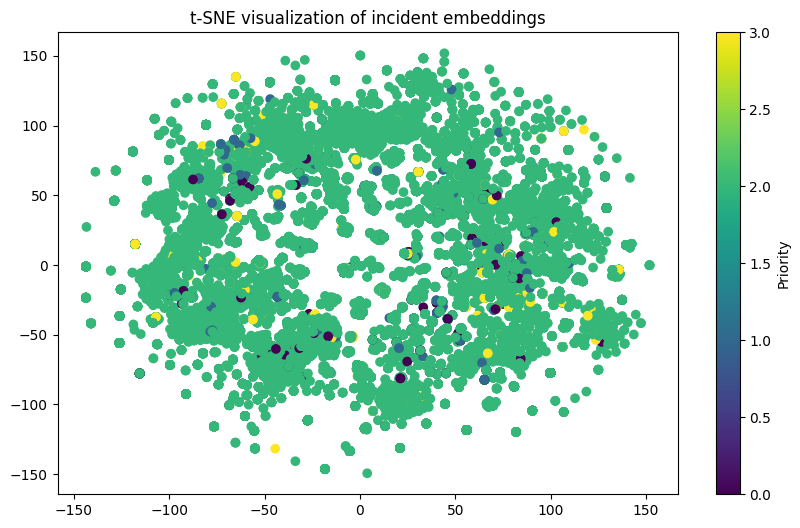

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
vis_data = tsne.fit_transform(symptom_embeddings)

plt.figure(figsize=(10,6))
plt.scatter(vis_data[:,0], vis_data[:,1], c=df_unique['priority'].astype('category').cat.codes, cmap='viridis')
plt.colorbar(label='Priority')
plt.title("t-SNE visualization of incident embeddings")
plt.show()


In [7]:
import joblib
import pickle

model.save('incident_model_embedding/')

faiss.write_index(index, 'incident_faiss.index')

df_unique.to_pickle('incident_df.pkl')
